
  ****READING THE DATA


In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [52]:
x = r"C:\Users\zaxak\Desktop\Train.csv"
df = pd.read_csv(x)
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


>DATA CLEAN




In [53]:
from scipy.stats import iqr 
import numpy as np 

# 1. Start with a filter that includes all rows (True for every row)
#    This will be our combined non-outlier filter
combined_filter = pd.Series(True, index=df.index)

print(f"Number of rows before outlier removal: {len(df)}")
print(f"Number of rows for each column after outlier removal:")

# List of columns to check for outliers
cols_to_check = [
    'Customer_care_calls', 'Customer_rating', 'Prior_purchases',
    'Cost_of_the_Product', 'Discount_offered', 'Weight_in_gms'
]

# 2. Loop through each column and update the combined filter
for col in cols_to_check:
    column_data = df[col]
    
    # Calculate IQR and thresholds
    iqr_val = iqr(column_data)
    lower_threshold = np.quantile(column_data, 0.25) - 1.5 * iqr_val
    upper_threshold = np.quantile(column_data, 0.75) + 1.5 * iqr_val
    
    # Check for non-outliers in the CURRENT column
    # (True for any row where data is within the bounds)
    is_not_outlier_in_col = (column_data > lower_threshold) & (column_data < upper_threshold)
    
    # Update the combined filter: 
    # A row is kept only if it was already True AND it is a non-outlier in the current column
    combined_filter = combined_filter & is_not_outlier_in_col

    # NOTE: The row count printout in the original code was flawed, 
    # so we just print the name here for simplicity.
    print(f"{col} thresholds calculated.")

# 3. Apply the combined filter once
df = df[combined_filter]

print(f"\nNumber of rows after outlier removal (combined filter): {len(df)}")   
    

Number of rows before outlier removal: 10999
Number of rows for each column after outlier removal:
Customer_care_calls thresholds calculated.
Customer_rating thresholds calculated.
Prior_purchases thresholds calculated.
Cost_of_the_Product thresholds calculated.
Discount_offered thresholds calculated.
Weight_in_gms thresholds calculated.

Number of rows after outlier removal (combined filter): 7919


FEATURE ENGINEERING

In [54]:

# Create a boolean mask for categorical columns
categorical_mask = (df.dtypes == 'object')

# Get list of categorical column names
categorical_columns = df.columns[categorical_mask].tolist()

# Print the head of the categorical columns
print(df[categorical_columns].head())

# Create LabelEncoder object: le
le = LabelEncoder()
# Apply LabelEncoder to categorical columns
df[categorical_columns] = df[categorical_columns].apply(lambda x: le.fit_transform(x))


print(df[categorical_columns].head())

   Warehouse_block Mode_of_Shipment Product_importance Gender
3                B           Flight             medium      M
5                F           Flight             medium      F
6                D           Flight                low      F
8                A           Flight                low      F
10               C           Flight             medium      M
    Warehouse_block  Mode_of_Shipment  Product_importance  Gender
3                 1                 0                   2       1
5                 4                 0                   2       0
6                 3                 0                   1       0
8                 0                 0                   1       0
10                2                 0                   2       1


In [55]:
# Feature 1: Discount as a Ratio of Product Cost
df['Discount_as_Ratio'] = df['Discount_offered'] / df['Cost_of_the_Product']

# Feature 2: Customer Engagement Ratio (Care per Purchase)
df['Care_per_Purchase'] = df['Customer_care_calls'] / (df['Prior_purchases'] + 1e-6)

# Feature 3: Product Value Density (Cost per Gram)
# Uses a small value in the denominator to prevent division by zero, though weight is unlikely to be 0.
df['Value_Density'] = df['Cost_of_the_Product'] / (df['Weight_in_gms'] + 1e-6)

# Feature 4: Effective Purchase Rating
# Uses natural log (log) of (Prior_purchases + 1) to dampen the effect of high purchase counts.
df['Effective_Rating'] = df['Customer_rating'] * np.log(df['Prior_purchases'] + 1)

# Identify all numerical and the newly created combination columns
numerical_cols = [
     'Cost_of_the_Product', 
    'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 
    'Reached.on.Time_Y.N', 
    'Discount_as_Ratio', 'Care_per_Purchase', 'Value_Density', 'Effective_Rating',
]

# Create the final DataFrame with only numerical columns
df = df[numerical_cols].copy()
df = df.rename(columns={'Reached.on.Time_Y.N': 'Target_On_Time'})

# Display the first few rows showing the new features
print("DataFrame with four new numerical combinations:")
print(df.head())

DataFrame with four new numerical combinations:
    Cost_of_the_Product  Prior_purchases  Discount_offered  Weight_in_gms  \
3                   176                4                10           1177   
5                   162                3                12           1417   
6                   250                3                 3           2371   
8                   150                3                11           1861   
10                  189                2                12           2888   

    Target_On_Time  Discount_as_Ratio  Care_per_Purchase  Value_Density  \
3                1           0.056818           0.750000       0.149533   
5                1           0.074074           1.000000       0.114326   
6                1           0.012000           1.000000       0.105441   
8                1           0.073333           1.000000       0.080602   
10               1           0.063492           1.499999       0.065443   

    Effective_Rating  
3           4.8

DATA SPLIT

In [43]:
# Target variable (y): Select the column you want to predict
y = df['Target_On_Time']

# Features (X): Select all other columns by dropping the target variable
X = df.drop('Target_On_Time', axis=1)

In [44]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. CRITICAL: SAVE the original column names BEFORE scaling
original_columns = X_train.columns

scaler = StandardScaler()

# 2. Fit and transform the training data
# This results in a NumPy array.
X_train_scaled_array = scaler.fit_transform(X_train)

# 3. Convert the scaled array back to a DataFrame, 
#    re-applying the original column names
X_train = pd.DataFrame(X_train_scaled_array, columns=original_columns)

# 4. Transform X_test using the same fitted scaler
X_test_scaled_array = scaler.transform(X_test)

# 5. Convert X_test back to a DataFrame (assuming X_test also needs column names)
#    Note: X_test's original columns should be the same as X_train's
X_test = pd.DataFrame(X_test_scaled_array, columns=original_columns)


****MODEL CREATION*******

In [45]:
#RANDOM FOREST CLASSIFIER


rf_model = RandomForestClassifier(random_state=42).fit(
  X_train, y_train)

# Use it to predict the labels of the test data
rf_predictions = rf_model.predict(X_test)
y_probalities_RF = rf_model.predict_proba(X_test)
y_probs_rf = y_probalities_RF[:, 1]


In [46]:
print('accuracy:',accuracy_score(y_test,rf_predictions))
print('f1:',f1_score(y_test,rf_predictions))
print(confusion_matrix(y_test,rf_predictions))
print('recall:',recall_score(y_test,rf_predictions))
print('precision:',precision_score(y_test,rf_predictions))
print('auc:',roc_auc_score(y_test,y_probs_rf))

accuracy: 0.5877525252525253
f1: 0.5352313167259787
[[555 250]
 [403 376]]
recall: 0.48267008985879334
precision: 0.6006389776357828
auc: 0.6134086541911512


In [47]:
#SVM
svc_model = SVC(random_state=42, probability=True)
svc_model.fit(X_train, y_train)

# Get predictions and probabilities
svc_predictions = svc_model.predict(X_test)
svc_probabilities = svc_model.predict_proba(X_test)[:, 1] # Probability of the positive class (1)

# Evaluate Baseline Performance
print("--- SVC BASELINE METRICS (Default Settings) ---")
print('Accuracy:', accuracy_score(y_test, svc_predictions))
print('F1:', f1_score(y_test, svc_predictions))
print('AUC:', roc_auc_score(y_test, svc_probabilities))
print('Confusion Matrix:\n', confusion_matrix(y_test, svc_predictions))
print('Recall:', recall_score(y_test, svc_predictions))
print('Precicion:',precision_score(y_test, svc_predictions))

--- SVC BASELINE METRICS (Default Settings) ---
Accuracy: 0.5902777777777778
F1: 0.49961449498843485
AUC: 0.6236431481673431
Confusion Matrix:
 [[611 194]
 [455 324]]
Recall: 0.4159178433889602
Precicion: 0.6254826254826255


In [25]:
#LOGISTIC REGRESIION
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression().fit(X_train,y_train)
log_preds=log_reg.predict(X_test)
y_probalities_log = log_reg.predict_proba(X_test)
y_probs_log = y_probalities_log[:, 1]


In [26]:
print('accuracy:',accuracy_score(y_test,log_preds))
print('f1:',f1_score(y_test,log_preds))
print(confusion_matrix(y_test,log_preds))
print('recall:',recall_score(y_test,log_preds))
print('precision:',precision_score(y_test,log_preds))
print('auc:',roc_auc_score(y_test,y_probs_log))

accuracy: 0.5915404040404041
f1: 0.5683789192795197
[[511 294]
 [353 426]]
recall: 0.5468549422336328
precision: 0.5916666666666667
auc: 0.6286702971639067


In [27]:
#KNN
import matplotlib.pyplot as plt
from sklearn.neighbors  import KNeighborsClassifier


	# Set up a KNN Classifier
knn = KNeighborsClassifier().fit(X_train,y_train)
  #  accuracy
knn_predicts=knn.predict(X_test)
y_probalities_knn = knn.predict_proba(X_test)
y_probs_knn = y_probalities_knn[:, 1]




In [28]:
print('accuracy:',accuracy_score(y_test,knn_predicts))
print('f1:',f1_score(y_test,knn_predicts))
print(confusion_matrix(y_test,knn_predicts))
print('recall:',recall_score(y_test,knn_predicts))
print('precision:',precision_score(y_test,knn_predicts))
print('auc:',roc_auc_score(y_test,y_probs_knn))

accuracy: 0.5561868686868687
f1: 0.5335102853351028
[[479 326]
 [377 402]]
recall: 0.5160462130937099
precision: 0.5521978021978022
auc: 0.5838700675336272


In [29]:
#DECISION TREE


Dec_Tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
predictions=Dec_Tree.predict(X_test)
y_probalities_dec = Dec_Tree.predict_proba(X_test)
y_probs_dec = y_probalities_dec[:, 1]



In [30]:
print('accuracy:',accuracy_score(y_test,predictions))
print('f1:',f1_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print('recall:',recall_score(y_test,predictions))
print('precision:',precision_score(y_test,predictions))
print('auc:',roc_auc_score(y_test,y_probs_dec))

accuracy: 0.553030303030303
f1: 0.5552763819095478
[[434 371]
 [337 442]]
recall: 0.5673940949935815
precision: 0.5436654366543665
auc: 0.5532622648880952


In [31]:
#XGBOOST
from xgboost import XGBClassifier
Xgboost=XGBClassifier(random_state=42).fit(X_train,y_train)
Xg_preds=Xgboost.predict(X_test)
y_probalities_xg = Xgboost.predict_proba(X_test)
y_probs_xg = y_probalities_xg[:, 1]


In [32]:
print('accuracy:',accuracy_score(y_test,Xg_preds))
print('f1:',f1_score(y_test,Xg_preds))
print(confusion_matrix(y_test,Xg_preds))
print('recall:',recall_score(y_test,Xg_preds))
print('precision:',precision_score(y_test,Xg_preds))
print('auc:',roc_auc_score(y_test,y_probs_xg))

accuracy: 0.5763888888888888
f1: 0.5400959561343386
[[519 286]
 [385 394]]
recall: 0.5057766367137355
precision: 0.5794117647058824
auc: 0.6082961911672075


#*****************HYPERPARAMETERS

In [33]:
#What are the hyperparameters for each model ?
#KNN
print('KNN:',knn.get_params().keys())
#RANDOM FOREST CLASSIFIER
print('Random Forest:',rf_model.get_params().keys())
print('Decision Tree:',Dec_Tree.get_params().keys())
print('Xgboost',Xgboost.get_params().keys())
print('Logistic regression:',log_reg.get_params().keys())
print('SVM:',svc_model.get_params().keys())

KNN: dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])
Random Forest: dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
Decision Tree: dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter'])
Xgboost dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'device', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'feature_weights', 'gamma', 'grow_policy', 'importance_type', 'interaction_cons

DECISION TREE TUNING


In [34]:
#GRIDSEARCH FOR DECICION TREE
param_grid_DCT={'criterion' : ["gini", "entropy",'log_loss'],
               'max_depth' : [None, 5, 10, 20],
               'splitter' : ["best", "random"],
               'min_samples_split' : [2,5,10,20],
               'min_samples_leaf' : [1,5,10,20],
            'class_weight': [None,'balanced',{0: 1, 1: 5},{0: 1, 1: 10} ],}
                
grid_DCT=GridSearchCV(DecisionTreeClassifier(random_state=42),param_grid_DCT,cv=5,n_jobs=-1,scoring='roc_auc')
grid_DCT.fit(X_train,y_train)
grid_DCT.best_params_


{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'splitter': 'best'}

In [35]:
#More Decicision Tree Hyperparameters to tune
param_grid_DCT2={'min_weight_fraction_leaf': [0.0, 0.001, 0.01, 0.05, 0.1, 0.2],
            'max_features': ['sqrt', 'log2'],
            'max_leaf_nodes': [5, 10, 25, 50, 100, 200, None],
            'min_impurity_decrease': [0.0, 0.001, 0.01, 0.05, 0.1, 0.2],
'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.05, 0.1]}
grid_DCT2=GridSearchCV(DecisionTreeClassifier(random_state=42),param_grid_DCT2,cv=5,n_jobs=-1,scoring='roc_auc')
grid_DCT2.fit(X_train,y_train)
grid_DCT2.best_params_

{'ccp_alpha': 0.0,
 'max_features': 'sqrt',
 'max_leaf_nodes': 50,
 'min_impurity_decrease': 0.0,
 'min_weight_fraction_leaf': 0.001}

In [36]:
best_params = {
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'splitter': 'best',
 'ccp_alpha': 0.0,
 'max_features': 'sqrt',
 'max_leaf_nodes': 50,
 'min_impurity_decrease': 0.00,
 'min_weight_fraction_leaf': 0.001}
Dec_Tree_tuned=DecisionTreeClassifier(**best_params,random_state=42) 
Dec_Tree_tuned.fit(X_train,y_train)
predict=Dec_Tree_tuned.predict(X_test)

y_proba_all_dec = Dec_Tree_tuned.predict_proba(X_test)
y_scores_dec = y_proba_all_dec[:, 1]


In [37]:
print('accuracy:',accuracy_score(y_test,predict))
print('f1:',f1_score(y_test,predict))
print(confusion_matrix(y_test,predict))
print('recall:',recall_score(y_test,predict))
print('precision:',precision_score(y_test,predict))
print('AUC',roc_auc_score(y_test,y_scores_dec))

accuracy: 0.6041666666666666
f1: 0.355601233299075
[[784  21]
 [606 173]]
recall: 0.2220795892169448
precision: 0.8917525773195877
AUC 0.6153046986501248


*KNN TUNING and complexity visualization


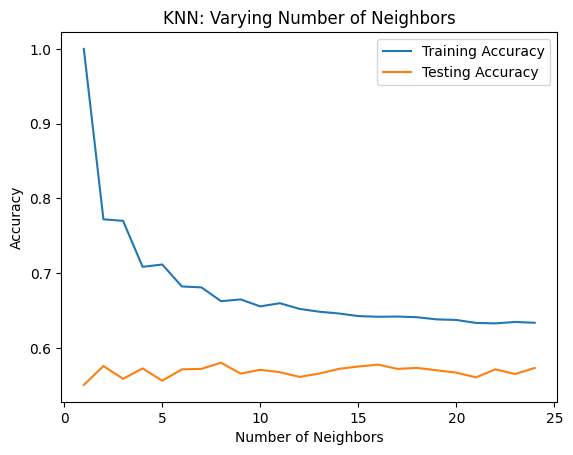

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
 {np.int64(1): 1.0, np.int64(2): 0.7720599842146804, np.int64(3): 0.7700078926598264, np.int64(4): 0.7084451460142068, np.int64(5): 0.7116022099447514, np.int64(6): 0.6822415153906867, np.int64(7): 0.6809786898184689, np.int64(8): 0.662509865824783, np.int64(9): 0.6648776637726914, np.int64(10): 0.6555643251775849, np.int64(11): 0.65982636148382, np.int64(12): 0.652249408050513, np.int64(13): 0.6484609313338595, np.int64(14): 0.6460931333859511, np.int64(15): 0.642620363062352, np.int64(16): 0.6416732438831886, np.int64(17): 0.6419889502762431, np.int64(18): 0.6410418310970797, np.int64(19): 0.6382004735595895, np.int64(20): 0.6374112075769535, np.int64(21): 0.6334648776637727, np.int64(22): 0.6328334648776638, np.int64(23): 0.6347277032359905, np.int64(24): 0.6336227308603} 
 {np.int64(1): 0.5505050505050505, np.int64(2): 0.5757575757575758, np.int64(3): 0.5587121212121212, np.int64(4): 0.57260101010101, np.int

In [38]:
neighbors = np.arange(1, 25)
train_accuracies = {}
test_accuracies = {}
for neighbor in neighbors:
  
	# Set up a KNN Classifier
	knn = KNeighborsClassifier(n_neighbors=neighbor).fit(X_train,y_train)
  
	# Fit the model
	knn.fit(X_train, y_train)
  
	# Compute accuracy
	train_accuracies[neighbor] = knn.score(X_train, y_train)
	test_accuracies[neighbor] = knn.score(X_test, y_test)


# PLOT MODEL COMPLEXITY
plt.title("KNN: Varying Number of Neighbors")

# Plot training accuracies
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")

# Plot test accuracies
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")

plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")

# Display the plot
plt.show()
print(neighbors, '\n', train_accuracies, '\n', test_accuracies)


In [39]:
# Find the key corresponding to the maximum value
best_key = max(test_accuracies, key=test_accuracies.get)
best_value = test_accuracies[best_key]

print(f"K={best_key} is the best value for the hyperparameter 'n_neighbors', to maximize accuracy ")
print(f"Highest value: {best_value:.4f}")


K=8 is the best value for the hyperparameter 'n_neighbors', to maximize accuracy 
Highest value: 0.5802


In [40]:
#More KNN hyperparameters to tune
param_grid_KNN={'n_neighbors': range(1,26),
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [20,30,40],
'p': [1,2],
'metric' : ['minkowski','manhattan'],
}
grid_knn=GridSearchCV(KNeighborsClassifier(),param_grid_KNN,cv=5,n_jobs=-1,scoring='roc_auc')
grid_knn.fit(X_train,y_train)
grid_knn.best_params_

{'algorithm': 'auto',
 'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 25,
 'p': 1,
 'weights': 'uniform'}

In [41]:
best_knn_params={'algorithm': 'auto',
 'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 25,
 'p': 1,
 'weights': 'uniform',
 'n_jobs': -1}
Tuned_KNN=KNeighborsClassifier(**best_knn_params)
Tuned_KNN.fit(X_train,y_train)
KNN_predictionS=Tuned_KNN.predict(X_test)
y_proba_all_KNN = Tuned_KNN.predict_proba(X_test)
y_scores_KNN = y_proba_all_KNN[:, 1]

In [42]:
print('accuracy:',accuracy_score(y_test,KNN_predictionS))
print('f1:',f1_score(y_test,KNN_predictionS))
print(confusion_matrix(y_test,KNN_predictionS))
print('recall:',recall_score(y_test,KNN_predictionS))
print('precision:',precision_score(y_test,KNN_predictionS))
print('AUC',roc_auc_score(y_test,y_scores_KNN))

accuracy: 0.5751262626262627
f1: 0.49738610903659447
[[578 227]
 [446 333]]
recall: 0.4274711168164313
precision: 0.5946428571428571
AUC 0.6034053851489806


**RANDOMFOREST TUNE


In [43]:
# RANDOM FOREST TUNING
param_grid_RF = {'n_estimators': range(10, 50, 10),
              'criterion' : ["gini", "entropy",'log_loss'],
               'max_depth' : [None, 5, 10, 20],
               'bootstrap' : [True, False],
               'min_samples_split' : [2,5,10,20],
               'min_samples_leaf' : [1,5,10,20],
               'max_features':['sqrt', 'log2',0.5,0.8],
            }

# Optimize for a RandomForestClassifier() using GridSearchCV
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_RF, cv=5,n_jobs=-1,scoring='roc_auc')
grid.fit(X_train, y_train)
grid.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 10}

In [44]:
best_rf_params={'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 10}
Tuned_RF=RandomForestClassifier(**best_rf_params,random_state=42,n_jobs=-1)
Tuned_RF.fit(X_train,y_train)
rf_tuned_predictions=Tuned_RF.predict(X_test)
y_proba_all_RF = Tuned_RF.predict_proba(X_test)
y_scores_RF = y_proba_all_RF[:, 1]




In [45]:
print('accuracy:',accuracy_score(y_test,rf_tuned_predictions))
print('f1:',f1_score(y_test,rf_tuned_predictions))
print(confusion_matrix(y_test,rf_tuned_predictions))
print('recall:',recall_score(y_test,rf_tuned_predictions))
print('precision:',precision_score(y_test,rf_tuned_predictions))

print('AUC',roc_auc_score(y_test,y_scores_RF))


accuracy: 0.6041666666666666
f1: 0.4022878932316492
[[746  59]
 [568 211]]
recall: 0.27086007702182285
precision: 0.7814814814814814
AUC 0.6281711702373644


*LOG REGRESSION TUNE


In [46]:
param_grid_lg ={
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000], 
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }
   
   
grid_search_lg = GridSearchCV(LogisticRegression(solver='liblinear'),
    param_grid_lg,
    scoring='roc_auc',
    cv=5,                 # Use 5-fold cross-validation
    verbose=1,
    n_jobs=-1          # Use all available CPU cores
)
grid_search_lg.fit(X_train, y_train)
grid_search_lg.best_params_


Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'C': 100, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'saga'}

In [47]:
lg_best={'C': 100, 'max_iter': 1000, 'penalty': 'l1'}
Tuned_lg=LogisticRegression(**lg_best,random_state=42,solver='saga')
Tuned_lg.fit(X_train,y_train)
LG_tuned_predictions=Tuned_lg.predict(X_test)
y_proba_all_lg = Tuned_lg.predict_proba(X_test)
y_scores_lg = y_proba_all_lg[:, 1]


In [48]:
print(confusion_matrix(y_test,LG_tuned_predictions))
print('PRECICION:',precision_score(y_test,LG_tuned_predictions))
print('f1:',f1_score(y_test,LG_tuned_predictions))
print('recall',recall_score(y_test,LG_tuned_predictions))
print('accuracy',accuracy_score(y_test,LG_tuned_predictions))
y=roc_auc_score(y_test,y_scores_lg)
print('AUC',y)

[[510 295]
 [353 426]]
PRECICION: 0.5908460471567267
f1: 0.568
recall 0.5468549422336328
accuracy 0.5909090909090909
AUC 0.628791490922428


****SVM TUNE

In [49]:

param_grid_SVC = {
    'C': [0.1, 1, 10],            
    'kernel': ['rbf', 'poly'],    
    'gamma': ['scale', 'auto']    
}


grid_SVC = GridSearchCV(
    SVC(random_state=42, probability=True), 
    param_grid_SVC, 
    cv=5,                      
    n_jobs=-1,                 
    scoring='roc_auc'  # Optimizing for Area Under the ROC Curve
)

grid_SVC.fit(X_train, y_train)
grid_SVC.best_params_





{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

In [50]:
svm_best={'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Tuned_svm=SVC(**svm_best,random_state=42,probability=True)
Tuned_svm.fit(X_train,y_train)
SVM_tuned_predictions=Tuned_svm.predict(X_test)
y_proba_all_svm1 = Tuned_svm.predict_proba(X_test)
y_scores_svm1 = y_proba_all_svm1[:, 1]

In [51]:
print(confusion_matrix(y_test,SVM_tuned_predictions))
print('PRECICION:',precision_score(y_test,SVM_tuned_predictions))
print('f1:',f1_score(y_test,SVM_tuned_predictions))
print('recall',recall_score(y_test,SVM_tuned_predictions))
print('accuracy',accuracy_score(y_test,SVM_tuned_predictions))
y=roc_auc_score(y_test,y_scores_svm1)
print('AUC',y)

[[746  59]
 [582 197]]
PRECICION: 0.76953125
f1: 0.38067632850241545
recall 0.25288831835686776
accuracy 0.5953282828282829
AUC 0.6186399189915404



***XGBOOST TUNE


In [52]:
param_grid_XG = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        }
grid_XG = GridSearchCV(XGBClassifier(random_state=42), param_grid_XG, cv=5,n_jobs=-1,scoring='roc_auc')
grid_XG.fit(X_train, y_train)
grid_XG.best_params_


{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}

In [53]:
param_grid_XG1 = {
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma':[0, 0.1, 0.2],
        'min_child_weight':[1, 3, 5, 7],
        'grow_policy':['depthwise','lossguide'],
        'booster':['gbtree','gblinear','dart'],
        }
grid_XG1 = GridSearchCV(XGBClassifier(random_state=42), param_grid_XG1, cv=5,n_jobs=-1,scoring='roc_auc')
grid_XG1.fit(X_train, y_train)
grid_XG1.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.8,
 'gamma': 0.1,
 'grow_policy': 'depthwise',
 'min_child_weight': 3}

In [54]:

xg_best={'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7,
'booster': 'gbtree',
'colsample_bytree': 0.8,
'gamma': 0.1,
'grow_policy': 'depthwise',
'min_child_weight': 3,
}

Tuned_xg=XGBClassifier(**xg_best,random_state=42,n_jobs=-1,eval_metric="auc")
  # metric to track
Tuned_xg.fit(X_train,y_train)
XG_tuned_predictions=Tuned_xg.predict(X_test)
y_proba_all = Tuned_xg.predict_proba(X_test)
y_scores = y_proba_all[:, 1]


In [55]:
print(confusion_matrix(y_test,XG_tuned_predictions))
print('PRECICION:',precision_score(y_test,XG_tuned_predictions))
print('f1:',f1_score(y_test,XG_tuned_predictions))
print('recall',recall_score(y_test,XG_tuned_predictions))
print('accuracy',accuracy_score(y_test,XG_tuned_predictions))
y=roc_auc_score(y_test,y_scores)
print('auc',y)



[[777  28]
 [585 194]]
PRECICION: 0.8738738738738738
f1: 0.3876123876123876
recall 0.2490372272143774
accuracy 0.6130050505050505
auc 0.6297092147122845


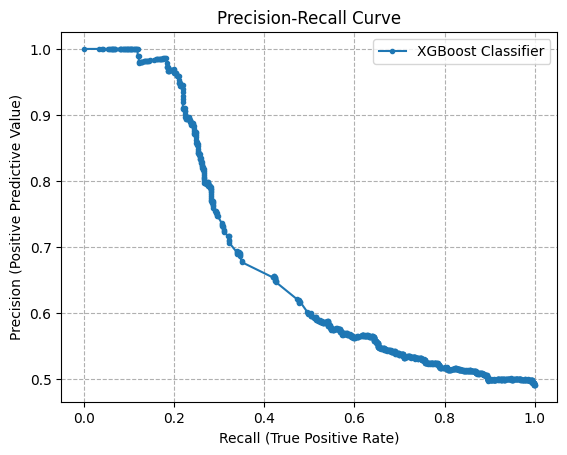

In [56]:
precision, recall, thresholds = precision_recall_curve(
         y_test,y_scores )
plt.plot(recall, precision, marker='.', label='XGBoost Classifier')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Curve')
plt.grid(True, linestyle='--')

plt.legend()



In [57]:
# Define your new optimal threshold
OPTIMAL_THRESHOLD = 0.477

# Convert probability scores (y_scores) into binary predictions (0 or 1)
# 1 if score >= threshold, else 0
y_pred_new = np.where(y_scores >= OPTIMAL_THRESHOLD, 1, 0)
new_recall = recall_score(y_test, y_pred_new)
new_precision = precision_score(y_test, y_pred_new)
new_cm = confusion_matrix(y_test, y_pred_new)
print('f1',f1_score(y_test, y_pred_new))
print('accuracy',accuracy_score(y_test, y_pred_new))
print('AUC',roc_auc_score(y_test,y_scores))


print(f"--- Performance at Threshold {OPTIMAL_THRESHOLD} ---")
print(f"New Recall:    {new_recall:.4f}")
print(f"New Precision: {new_precision:.4f}")
print(f"Confusion Matrix:\n{new_cm}")

f1 0.44346289752650175
accuracy 0.6022727272727273
AUC 0.6297092147122845
--- Performance at Threshold 0.477 ---
New Recall:    0.3222
New Precision: 0.7110
Confusion Matrix:
[[703 102]
 [528 251]]


In [58]:
for i, item in enumerate(Tuned_xg.feature_importances_):
      # Use i and item to print out the feature importance of each column
    print("{0:s}: {1:.2f}".format(X_train.columns[i], item))

Cost_of_the_Product: 0.06
Prior_purchases: 0.17
Discount_offered: 0.36
Weight_in_gms: 0.11
Discount_as_Ratio: 0.05
Care_per_Purchase: 0.02
Value_Density: 0.22
Effective_Rating: 0.02


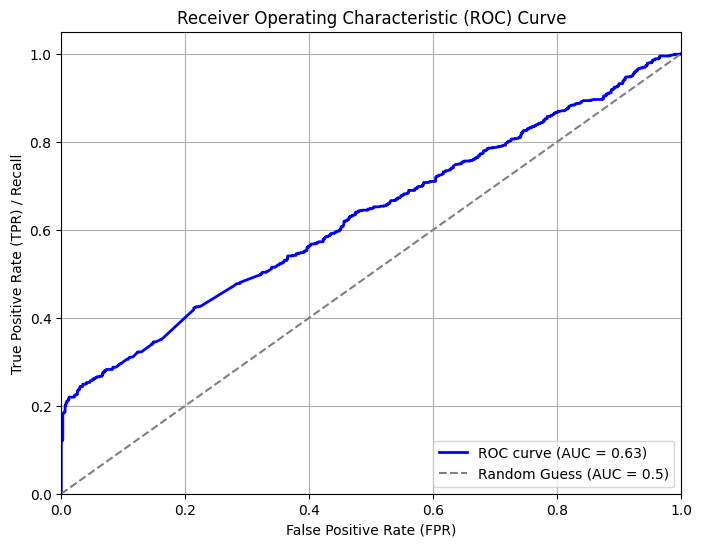

In [59]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = 0.63)')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()